![](http://)# Predict remaining days before reaching peak
In this Notebook, I used SIR model to predict the remaining days needed before reaching the peak of infections in a given country.

This value can be used as a feature to train your ML model.

Reference for SIR model : [https://www.kaggle.com/saga21/covid-global-forecast-sir-model-ml-regressions/notebook](https://www.kaggle.com/saga21/covid-global-forecast-sir-model-ml-regressions/notebook)

In [8]:
# provide a country and its population here
country = 'India'
country_population = 1339200000

In [9]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from scipy import integrate, optimize

submission_example = pd.read_csv("../input/covid19-global-forecasting-week-2/submission.csv")
test = pd.read_csv("../input/covid19-global-forecasting-week-2/test.csv")
train = pd.read_csv("../input/covid19-global-forecasting-week-2/train.csv")

In [10]:
def sir_model(y, x, beta, gamma):
    sus = -beta * y[0] * y[1] / N
    rec = gamma * y[1]
    inf = -(sus + rec)
    return sus, inf, rec

def fit_odeint(x, beta, gamma):
    return integrate.odeint(sir_model, (sus0, inf0, rec0), x, args=(beta, gamma))[:,1]

In [11]:
def fit_sir_country(country, country_pop, initial_date, additional_sim_days):
    """
    Fit the SIR curve with real values of a country starting from the initial_date
    
    Returns:
    remaining_to_peak = remaining days before we reach the peak of infections
    ydata = real infection data
    fitted = simulated infection data
    xdata = days vector of real data
    xdata2 = extended vector of days taking into consideration future predictions
    """
    population = float(country_pop)
    confirmed_total_date_country = train[train['Country_Region']==country].groupby(['Date']).agg({'ConfirmedCases':['sum']})
    fatalities_total_date_country = train[train['Country_Region']==country].groupby(['Date']).agg({'Fatalities':['sum']})
    total_date_country = confirmed_total_date_country.join(fatalities_total_date_country)
    country_df = total_date_country[(initial_date+1):]
    country_df['day_count'] = list(range(1,len(country_df)+1))

    ydata = [i for i in country_df.ConfirmedCases['sum'].values]
    xdata = country_df.day_count
    ydata = np.array(ydata, dtype=float)
    xdata = np.array(xdata, dtype=float)

    N = population
    inf0 = ydata[0]
    sus0 = N - inf0
    rec0 = 0.0
    
    def sir_model(y, x, beta, gamma):
        sus = -beta * y[0] * y[1] / N
        rec = gamma * y[1]
        inf = -(sus + rec)
        return sus, inf, rec

    def fit_odeint(x, beta, gamma):
        return integrate.odeint(sir_model, (sus0, inf0, rec0), x, args=(beta, gamma))[:,1]

    sim_length = len(xdata) + additional_sim_days # Length of simulation
    xdata2 = np.arange(1,sim_length)
    popt, pcov = optimize.curve_fit(fit_odeint, xdata, ydata)
    fitted = fit_odeint(xdata2, *popt)
    print("Initial Start day : ", initial_date, " Optimal parameters: beta =", popt[0], " and gamma = ", popt[1])
    remaining_to_peak = np.argmax(fitted) - len(xdata)
    print("   Remaining days to reach global peak infected cases : ", remaining_to_peak)
    return remaining_to_peak, ydata, fitted, xdata, xdata2

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Initial Start day :  10  Optimal parameters: beta = -0.08020598235718449  and gamma =  -0.19033505620025928
   Remaining days to reach global peak infected cases :  38


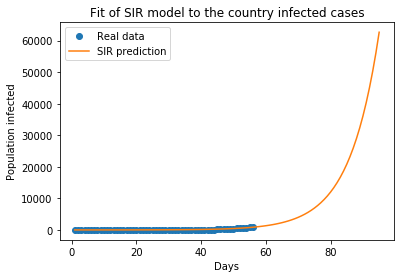

In [12]:
# Fit SIR to the corresponding country and for the initial simulation start date
remaining_to_peak, ydata, fitted, xdata, xdata2 = fit_sir_country(country, country_population, 10, 40)
plt.plot(xdata, ydata, 'o', label='Real data')
plt.plot(xdata2, fitted, label='SIR prediction')
plt.title("Fit of SIR model to the country infected cases")
plt.ylabel("Population infected")
plt.xlabel("Days")
plt.legend(loc='best')
plt.show()

In [13]:
remaining_days = []
# Loop on different initial start date for the simulation
for i in range(2,20):
    remaining_to_peak, _, _, _, _ = fit_sir_country(country, country_population, i, 40)
    remaining_days.append(remaining_to_peak)
print(remaining_days)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Initial Start day :  2  Optimal parameters: beta = 1.0  and gamma =  1.0
   Remaining days to reach global peak infected cases :  -64
Initial Start day :  3  Optimal parameters: beta = 1.0  and gamma =  1.0
   Remaining days to reach global peak infected cases :  -63
Initial Start day :  4  Optimal parameters: beta = 1.0  and gamma =  1.0
   Remaining days to reach global peak infected cases :  -62
Initial Start day :  5  Optimal parameters: beta = 1.0  and gamma =  1.0
   Remaining days to reach global peak infected cases :  -61
Initial Start day :  6  Optimal parameters: beta = 1.0  and gamma =  1.0
   Remaining days to reach global peak infected cases :  -60
Initial Start day :  7  Optimal parameters: beta = -0.001539202486044989  and gamma =  -0.11840323804032364
   Remaining days to reach global peak infected cases :  38
Initial Start day :  8  Optimal parameters: beta = 0.0001534708030994594  and gamma =  -0.11892255517539548
   Remaining days to reach global peak infected cases 

Here, we can see that -sometimes- we get negative duration values for some simulations. This is due to a bad fit between real data and SIR model. We can remove the negative values from that list and calculate the mean of the list to get an idea about the remaining days before the peak.

In [14]:
from scipy import stats

def rmNegative(L):
    index = len(L) - 1
    while index >= 0:
        if L[index] < 0:
            del L[index]
        index = index - 1

rmNegative(remaining_days)
stats.describe(remaining_days)
print("On average, the peak of infected cases in ", country, " is coming in : ", np.mean(remaining_days) ,"days")

On average, the peak of infected cases in  India  is coming in :  38.0 days
